# Testing the active branch

In [ ]:
def get_ds(args):
    """
    Gets data from disk and applies train/test split.
    """
    ds = getattr(pinot.data, args['data'])()
    partition = [int(a) for a in args['partition'].split(':')]
    ds_tr, ds_te = pinot.data.utils.split(ds, partition)
    return ds_tr, ds_te

def get_gpr(args):
    layer = pinot.representation.dgl_legacy.gn(model_name=args['layer'])

    net_representation = pinot.representation.Sequential(
        layer=layer,
        config=args['config'])

    kernel = pinot.inference.gp.kernels.deep_kernel.DeepKernel(
            representation=net_representation,
            base_kernel=pinot.inference.gp.kernels.rbf.RBF())

    gpr = pinot.inference.gp.gpr.exact_gpr.ExactGPR(
            kernel)
    return gpr

def move_to_cuda(ds_tr, ds_te, gpr):
    """
    If possible, moves datasets and network to GPU.
    """
    # send to GPU if possible
    if torch.cuda.is_available():
        move_ds_to_cuda = lambda x: [(g.to(torch.device('cuda:0')), y.to(torch.device('cuda:0'))) for g, y in x]
        ds_tr = move_ds_to_cuda(ds_tr)
        ds_te = move_ds_to_cuda(ds_te)
        gpr = gpr.to(torch.device('cuda:0'))
    return ds_tr, ds_te, gpr

def train_net(gpr, ds, args, print_out=False):
    """
    Runs training loop for the network.
    """
    # set up training parameters
    n_epochs, batch_size = args['n_epochs'], args['batch_size']
    
    if len(ds) < batch_size:
        batch_size = len(ds)
    
    # set up optimizer
    optimizer = pinot.app.utils.optimizer_translation(
        args['optimizer'],
        args['lr'],
        kl_loss_scaling=1.0/float(len(ds)))(gpr)

    # training loop
    for idx, epoch in enumerate(range(n_epochs)):
        ds_batches = pinot.data.utils.batch(ds, batch_size, seed=None)
        
        cum_loss = 0
        for ds_batch in ds_batches:
            batch_x, batch_y = ds_batch

            optimizer.zero_grad()
            loss = gpr.loss(batch_x, batch_y).mean()
            loss.backward()
            optimizer.step()
            
#             cum_loss += loss.item()

#         cum_loss /= len(ds_batches)
        
#         print(f'epoch {idx} loss: {cum_loss}')

    return gpr

def initialize_and_train_net(args):
    """
    Gets data, initializes and trains network, and returns data unbatched.
    """
    # get data
    ds_tr, ds_te = get_ds(args)
    
    # initialize network
    gpr = get_gpr(args)
    
#     move to cuda if possible
#     ds_tr, ds_te, gpr = move_to_cuda(ds_tr, ds_te, gpr)
    
    # train network
    gpr = train_net(gpr, ds_tr, args, print_out=True)
    
    return gpr, ds_tr, ds_te

In [2]:
args = {'layer': 'GraphConv',
 'noise_model': 'normal-heteroschedastic',
 'optimizer': 'adam',
 'config': [32, 'tanh', 32, 'tanh', 32, 'tanh'],
 'out': 'result',
 'data': 'esol',
 'batch_size': 32,
 'opt': 'Adam',
 'lr': 1e-03,
 'partition': '4:1',
 'n_epochs': 40}

In [10]:
%load_ext autoreload
%autoreload 2

import torch
import sys

# sys.path.append('../pinot/')

import pinot
from pinot.active import experiment

# net, _, ds = initialize_and_train_net(args)
net = get_gpr(args)
ds = getattr(pinot.data, args['data'])()
ds = pinot.data.utils.batch(ds, len(ds), seed=None)

bo = pinot.active.experiment.SingleTaskBayesianOptimizationExperiment(
            net=net,
            data=ds[0],
            optimizer=torch.optim.Adam(net.parameters(), 1e-3),
            acquisition=pinot.active.acquisition.random,
            n_epochs_training=10,
            slice_fn = experiment._slice_fn_tuple,
            collate_fn = experiment._collate_fn_graph
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
x = bo.run(limit=100)

c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [390]:
# bo = pinot.active.experiment.SingleTaskBayesianOptimizationExperiment(
#             net=net,
#             data=ds[0],
#             optimizer=torch.optim.Adam(net.parameters(), 1e-3),
#             acquisition=pinot.active.acquisition.expected_improvement,
#             n_epochs_training=10,
#             slice_fn = pinot.active.experiment._slice_fn_tuple,
#             collate_fn = pinot.active.experiment._collate_fn_graph
# )

# set net to eval
net.eval()

# grab new data
new_data = bo.slice_fn(bo.data, bo.new)

# split input target
gs, ys = new_data

# collate
# gs = self.collate_fn(gs)

# get the predictive distribution
distribution = bo.net.condition(gs)

# workup
distribution = bo.workup(distribution)

score = bo.acquisition(distribution)

# finding correlation
sol_pred = score.detach().numpy()
sol_true = np.concatenate([d.detach().numpy()
                           for i, d in enumerate(ds[0][1])
                           if i in bo.new])

from scipy.stats import spearmanr
spearmanr(sol_pred, sol_true)

SpearmanrResult(correlation=0.6661462705248355, pvalue=1.376169049340558e-145)

Plotting acquisition choices over time.

In [394]:
import gif
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))

actual_sol = ds[0][1].squeeze().numpy()
x_axis = np.arange(len(actual_sol))

@gif.frame
def plot(x, y):
    plt.figure()
    plt.plot(actual_sol[actual_sol.argsort()])
    plt.scatter(x, y, c='r', s=64)
    plt.xlabel('Molecules sorted according to solubility')
    plt.ylabel('Molecule solubility')

frames = []
for idx in range(len(bo.old)):
    frame = plot(bo.old[:idx], actual_sol[actual_sol.argsort()[bo.old[:idx]]])
    frames.append(frame)

gif.save(frames, "example.gif", duration=100)

<Figure size 720x720 with 0 Axes>

Plotting best candidate so far.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_best(bo, actual_sol, acq_fn_name):

    best_at_k_step = []
    best_so_far = -np.inf
    for candidate in bo.old:
        if actual_sol[candidate] > best_so_far:
            best_so_far = actual_sol[candidate]
        best_at_k_step.append(best_so_far)

    plt.figure(figsize=(10, 10))
    plt.plot(best_at_k_step)
    plt.axhline(max(actual_sol), c='red')
    plt.xlabel('Time step')
    plt.ylabel('Best solubility so far')
    plt.title(f'Best solubility over time using {acq_fn_name} acquisition')
    
    plt.savefig(f'{acq_fn_name}.png')

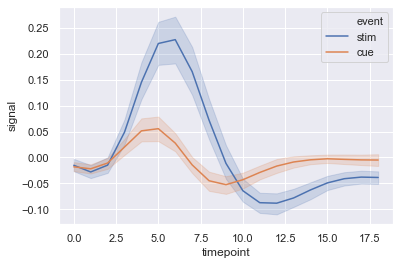

In [35]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
fmri = sns.load_dataset("fmri")
ax = sns.lineplot(x="timepoint", y="signal", hue="event",
                  data=fmri)

training: expected improvement
trial: 0


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


trial: 1


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


trial: 2


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


training: probability of improvement
trial: 0


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


trial: 1


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


trial: 2


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


training: upper confidence bound
trial: 0


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


trial: 1


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


trial: 2


c:\users\micha\miniconda3\envs\pinot\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


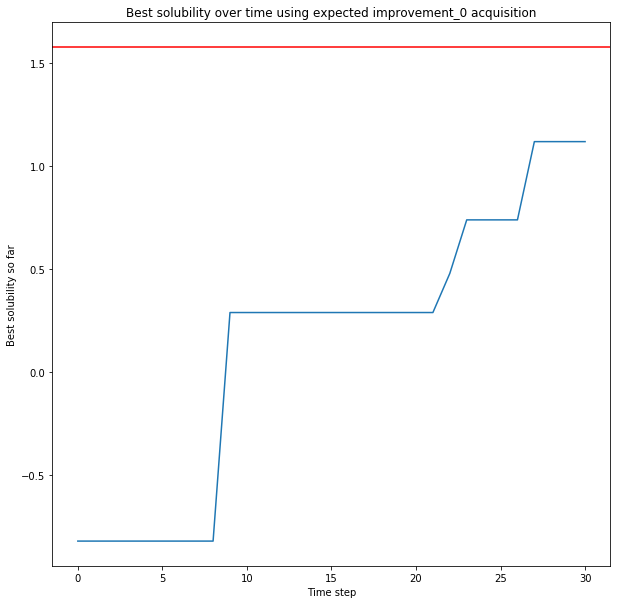

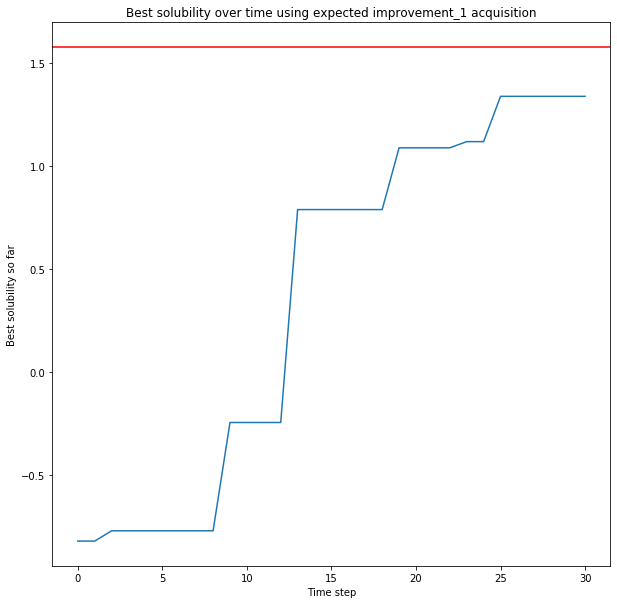

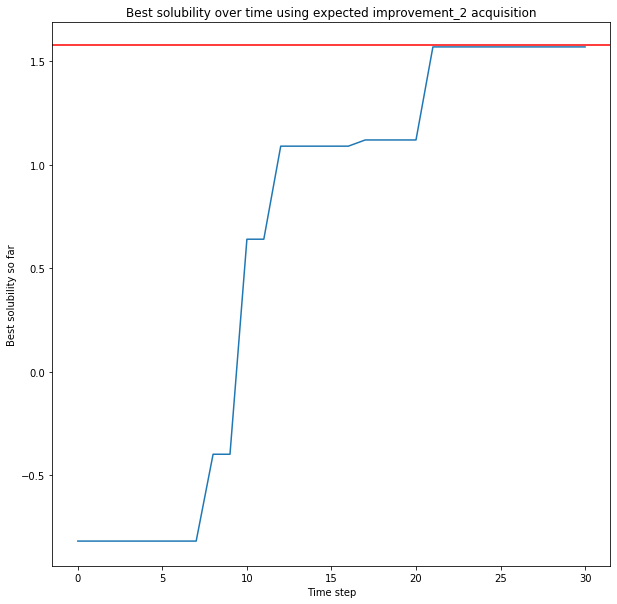

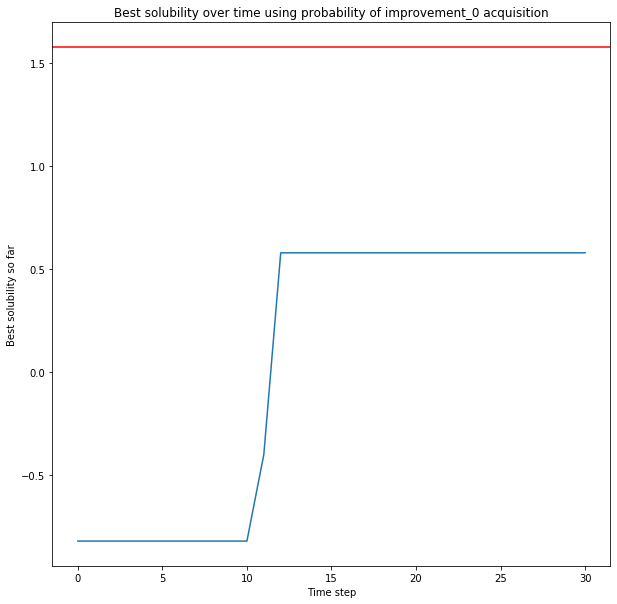

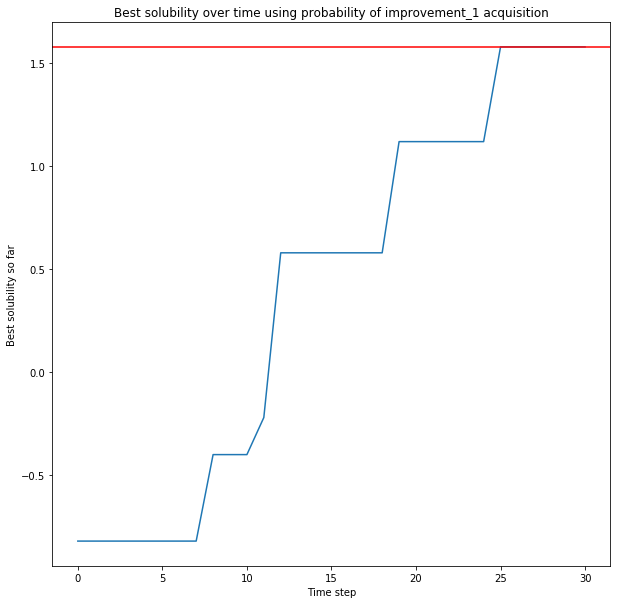

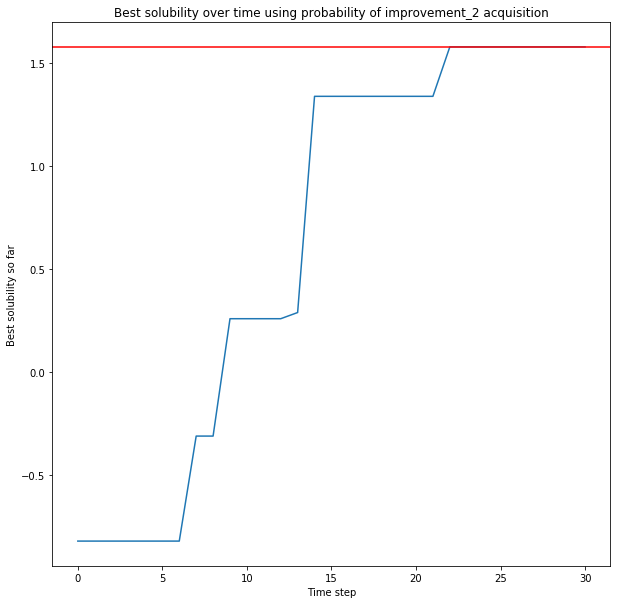

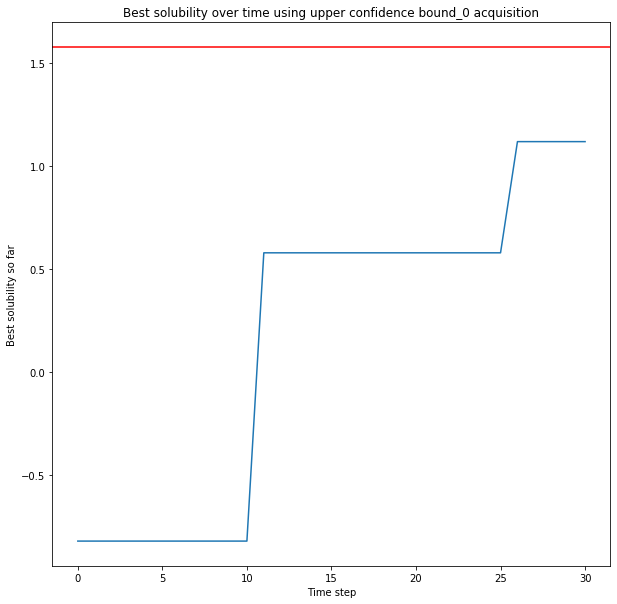

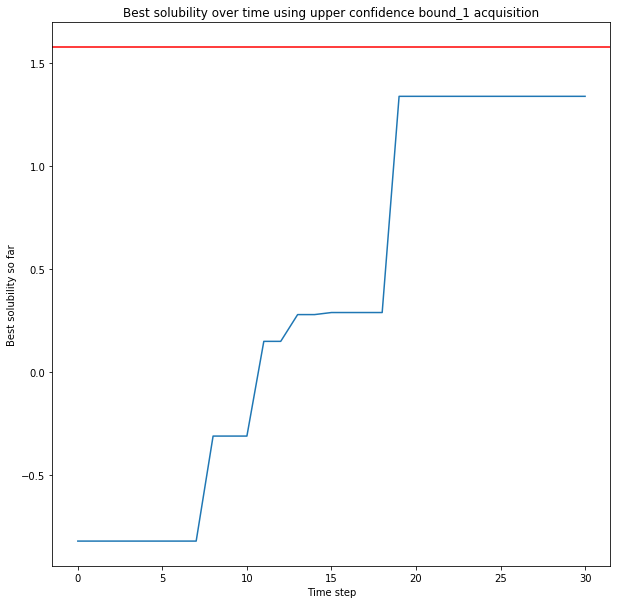

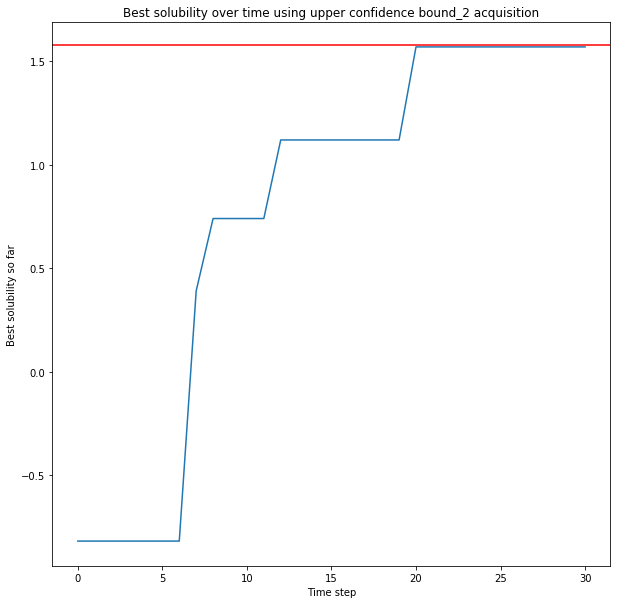

In [31]:
actual_sol = ds[0][1].squeeze().numpy()
acq_fns = {'expected improvement': pinot.active.acquisition.expected_improvement,
           'probability of improvement': pinot.active.acquisition.probability_of_improvement,
           'upper confidence bound': pinot.active.acquisition.upper_confidence_bound}

for acq_fn in acq_fns:
    
    print('training:', acq_fn)
    
    for i in range(3):
        print('trial:', i)

        # make fresh net
        net = get_gpr(args)
        bo = pinot.active.experiment.SingleTaskBayesianOptimizationExperiment(
                    net=net,
                    data=ds[0],
                    optimizer=torch.optim.Adam(net.parameters(), 1e-3),
                    acquisition=acq_fns[acq_fn],
                    n_epochs_training=10,
                    slice_fn = experiment._slice_fn_tuple,
                    collate_fn = experiment._collate_fn_graph
        )

        # run experiment
        x = bo.run(limit=30)
        plot_best(bo, actual_sol, f'{acq_fn}_{i}')